# component magnitudes at CB stations


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar

%matplotlib notebook

Load domain dimensions

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond  = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:]) 
tmask     = tmask[0,:,imin:imax,jmin:jmax]
tmask_full    = np.empty((12,50,imax-imin,jmax-jmin))
tmask_full[:] = tmask

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/Mn-set1-201910/ref-2015/ANHA12_EXH006_2015_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

In [31]:
# Load structure from sample dataset:
ref   = nc.Dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2015m01d05.nc',  'r')
lat_model = ref.variables['nav_lat'][imin:imax, jmin:jmax]
lon_model = ref.variables['nav_lon'][imin:imax, jmin:jmax]

In [35]:
turbo = np.array(ref.variables['sohmld'][0,imin:imax,jmin:jmax])
print('Average turbocline depth (m): ', np.average(turbo)) # 12 depth levels

Average turbocline depth (m):  16.910065


Load Mn model run results

In [9]:
def load_results(folder_ref, year):
    
    dmn_riv = np.empty((12,imax-imin,jmax-jmin))
    dmn_sed = np.empty((12,imax-imin,jmax-jmin))
    dmn_atm = np.empty((12,imax-imin,jmax-jmin))
    dmn_ice = np.empty((12,imax-imin,jmax-jmin))
    dmn_red = np.empty((12,50,imax-imin,jmax-jmin))
    dmn_oxi = np.empty((12,50,imax-imin,jmax-jmin))
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    
    i=0
    for month in months:
        file_comp = 'ANHA12_EXH006_1m_'+year+'0101_'+year+'1231_comp_'+year+month+'-'+year+month+'.nc'
        monthly   = nc.Dataset(folder_ref+file_comp)
        
        dmn_riv[i,:,:] = np.array(monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:] = np.array(monthly.variables['dmnsed'])[0,:,:]
        dmn_atm[i,:,:] = np.array(monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:] = np.array(monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:] = np.array(monthly.variables['dmnred'])[:,:,:]
        dmn_oxi[i,:,:,:] = np.array(monthly.variables['dmnoxi'])[:,:,:]
        
        i+=1
        
    dmn_riv = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_riv)
    dmn_sed = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_sed)
    dmn_atm = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_atm)
    dmn_ice = np.ma.masked_where((tmask_full[:,0,:,:] < 0.1), dmn_ice)
    dmn_red = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_oxi = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)
    
    return dmn_riv, dmn_sed, dmn_atm, dmn_ice, dmn_red, dmn_oxi

In [10]:
folder_spinup2  = '/data/brogalla/run_storage/ref-2005/'

In [11]:
dmn_riv, dmn_sed, dmn_atm, dmn_ice, dmn_red, dmn_oxi = load_results(folder_spinup2, '2005')

Volume of grid cells

In [18]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

In [19]:
e1t    = np.tile(e1t_base, (50,1,1))
e2t    = np.tile(e2t_base, (50,1,1))

In [20]:
volume3d  = e1t*e2t*e3t
area      = e1t_base*e2t_base

### Look at contributions at Canada Basin stations

In [13]:
CB1_i, CB1_j   = [458, 332]
CB2_i, CB2_j   = [508, 384]
CB3_i, CB3_j   = [547, 457]
CB4_i, CB4_j   = [629, 471]

<IPython.core.display.Javascript object>


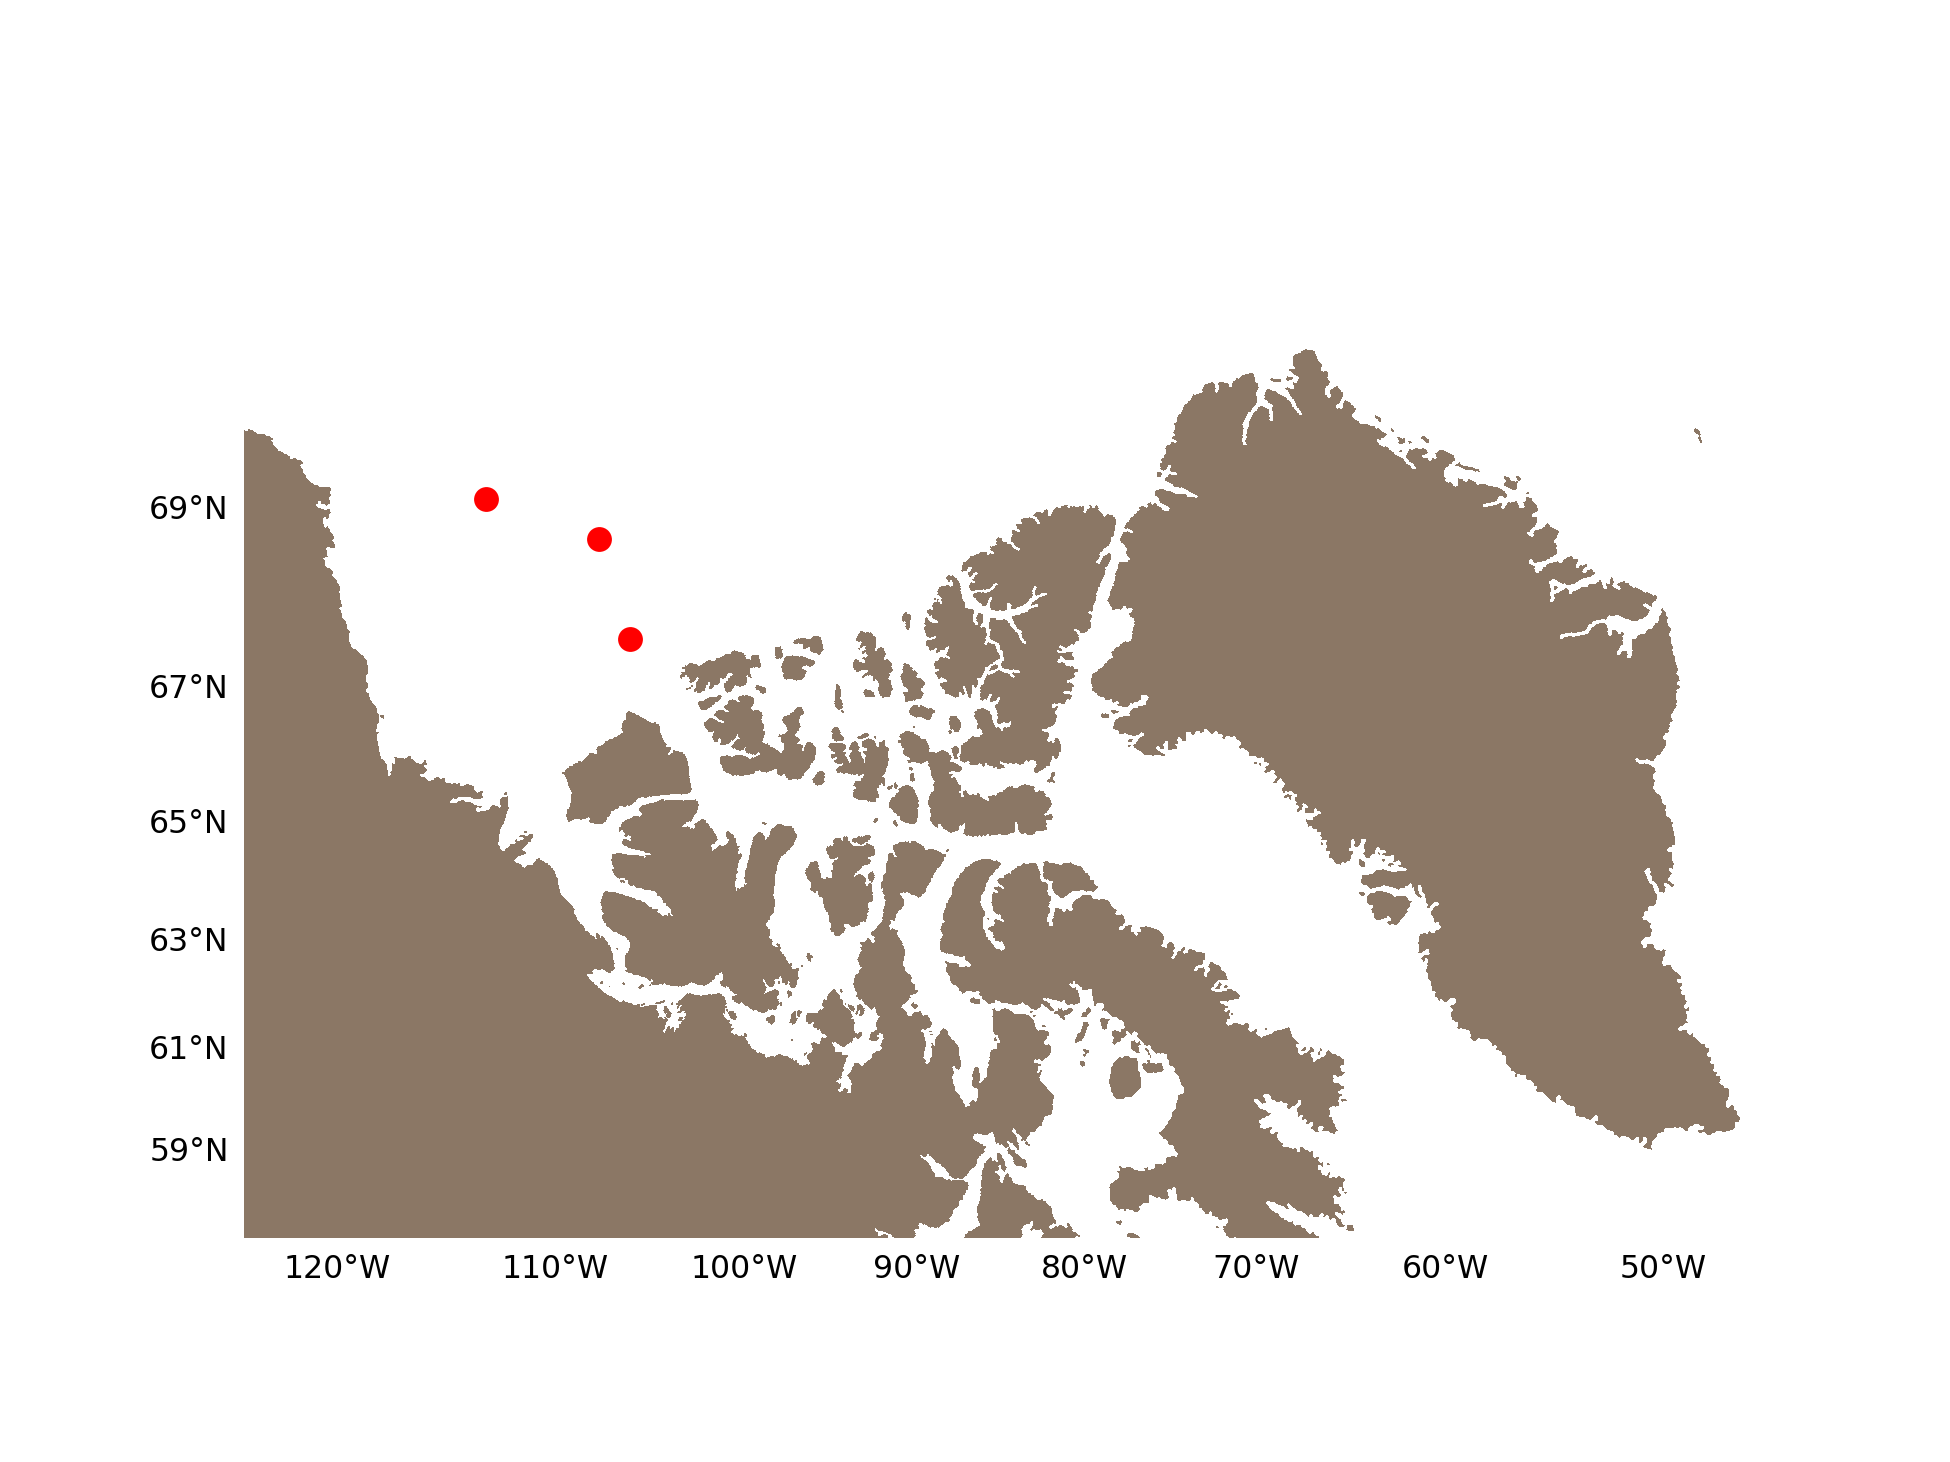

In [15]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))
#-----------------------------------------------------------------------------

x, y = proj1(lon_model, lat_model)

x_stn, y_stn = proj1([lon_model[CB2_i, CB2_j], lon_model[CB3_i, CB3_j], lon_model[CB4_i, CB4_j]], \
                     [lat_model[CB2_i, CB2_j], lat_model[CB3_i, CB3_j], lat_model[CB4_i, CB4_j]])

proj1.plot(x_stn, y_stn, '.r', markersize=20)

For now, let's assume that the components are in units of mol/L/s

In [39]:
turbo_depth = np.average(turbo)
turboz=11

In [88]:
def stn_components(stni, stnj, output=True):
    
    atm_stn = dmn_atm[:,stni,stnj]*e3t[0,stni,stnj]*1e3*1e6*3600*24*365 # micromol/m2/yr
    ice_stn = dmn_ice[:,stni,stnj]*e3t[0,stni,stnj]*1e3*1e6*3600*24*365
    riv_stn = dmn_riv[:,stni,stnj]*e3t[0,stni,stnj]*1e3*1e6*3600*24*365
    sed_stn = dmn_sed[:,stni,stnj]*e3t[0,stni,stnj]*1e3*1e6*3600*24*365
    red_stn = dmn_red[:,0:turboz,stni,stnj].mean(axis=0)*e3t[0:turboz,stni,stnj]*1e6*3600*24*365/turbo_depth
    oxi_stn = dmn_oxi[:,0:turboz,stni,stnj].mean(axis=0)*e3t[0:turboz,stni,stnj]*1e6*3600*24*365/turbo_depth

    
    if output:
        print('Contribution [micromol/m2/yr]')
        print('-----------------------------------')
        print('River:      ', "{0:.1E}".format(riv_stn.min()), ' - ', "{0:.1E}".format(riv_stn.max()))
        print('Sediment:   ', "{0:.1E}".format(sed_stn.min()), ' - ', "{0:.1E}".format(sed_stn.max()))
        print('Atmosphere: ', "{0:.1E}".format(atm_stn.min()), ' - ', "{0:.1E}".format(atm_stn.max()))
        print('Ice:        ', "{0:.1E}".format(ice_stn.min()), ' - ', "{0:.1E}".format(ice_stn.max()))
        print('-----------------------------------')
#         print('Reduction:  ', "{0:.1E}".format(red_stn.sum()))
#         print('Oxidation:  ', "{0:.1E}".format(oxi_stn.sum()))
#         print('-----------------------------------')
#         print('Sum:        ',"{0:.1E}".format(riv_stn.max()+sed_stn.max()+atm_stn.max()+ice_stn.max()+\
#                                               red_stn.sum()-oxi_stn.sum()))
    
    sum_stn = riv_stn.max()+sed_stn.max()+atm_stn.max()+ice_stn.max()+red_stn.sum()-oxi_stn.sum()

    return 

In [89]:
print('Missing component is: ', "{0:.1E}".format(4*turbo_depth), 'micromol/m2/yr')
print('                  or: ', "{0:.1E}".format(4*turbo_depth*1e-6*1e3*55/0.527), 'g/m2')

Missing component is:  6.8E+01 micromol/m2/yr
                  or:  7.1E+00 g/m2


In [90]:
stn_components(CB2_i, CB2_j)

Contribution [micromol/m2/yr]
-----------------------------------
River:       0.0E+00  -  0.0E+00
Sediment:    4.1E-06  -  4.1E-06
Atmosphere:  1.1E-05  -  3.1E-03
Ice:         3.3E-04  -  3.9E-01
-----------------------------------


In [91]:
stn_components(CB3_i, CB3_j)

Contribution [micromol/m2/yr]
-----------------------------------
River:       0.0E+00  -  0.0E+00
Sediment:    0.0E+00  -  0.0E+00
Atmosphere:  1.6E-05  -  2.7E-03
Ice:         2.6E-04  -  2.7E-01
-----------------------------------


In [92]:
stn_components(CB4_i, CB4_j)

Contribution [micromol/m2/yr]
-----------------------------------
River:       0.0E+00  -  0.0E+00
Sediment:    0.0E+00  -  0.0E+00
Atmosphere:  1.4E-05  -  2.7E-03
Ice:         3.0E-04  -  3.4E-01
-----------------------------------
